# Importation des packages 

Nous chargons les modules necessaires pour notre analyse. 

In [1]:
#Importation des packages

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
import os 

In [2]:
# Definir le repertoire de travail 
pwd = "C:\\Users\\mouss\\OneDrive\\Documents\\TotalEnergies" 
os.chdir(pwd) 
 
# Afficher le nouveau repertoire de travail 
print(os.getcwd()) 

C:\Users\mouss\OneDrive\Documents\TotalEnergies


# Données
Nous chargeons le jeu de données des transactions. Cette table contient **1 315 074** donées de transactions (lignes) et **8 facteurs**.

In [3]:
# Importation des données

data = pd.read_csv("table_transactions.csv"
                    ,sep = ";"
                    , encoding= 'latin-1'
                    , decimal=','
                  )

# Echantillon
Ci dessous un échantilon de cette table.

In [4]:
data.head()

,EP_CODE,TR_PRODUCT_CODE,TR_PRODUCT_TYPE,TR_SUPPORT_CODE,TR_DATE,TR_REVENUE,TR_VOLUME,TR_COUNT
0,87322382,730,Non-Fuel,C100,"02/08/21 00:00:00,000000000",132.12,0.00,35
1,87297430,102,Fuel,C100,"03/08/21 00:00:00,000000000",132.54,102.68,4
2,87128600,222,Fuel,C200,"03/08/21 00:00:00,000000000",323.46,227.94,11
3,87240226,112,Fuel,C700,"03/08/21 00:00:00,000000000",75.84,57.27,1
4,87185411,102,Fuel,C100,"03/08/21 00:00:00,000000000",2551.19,2036.94,41


# Nettoyage et preparation de données

## Types des variables et conversion

Dans cette partie, il s'agit de regarder de plus près le type de chaque variable et decider s'il est pertinent de les convertir vers d'autres types. Pour ce faire, analysons la sortie suivante : 

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315074 entries, 0 to 1315073
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   EP_CODE          1315074 non-null  int64  
 1   TR_PRODUCT_CODE  1315074 non-null  int64  
 2   TR_PRODUCT_TYPE  1315074 non-null  object 
 3   TR_SUPPORT_CODE  1313409 non-null  object 
 4   TR_DATE          1315074 non-null  object 
 5   TR_REVENUE       1315074 non-null  float64
 6   TR_VOLUME        1313053 non-null  float64
 7   TR_COUNT         1315074 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 80.3+ MB


On remaruqe que toute les variables sont de type *object* (correspondant à string) sauf EP_CODE, TR_PRODUCT_CODE, TR_COUNT, TR_REVENUE et TR_VOLUME qui sont numeriques. 

Le type *object* ne pose aucun problème pour les variables qui sont de nature categorielles. C'est le cas pour les variables TR_PRODUCT_TYPE et TR_SUPPORT_CODE. 

La variable TR_DATE est clairement de nature une date. Il est donc necessaire de convertir cette variable variable au bon format (date time). 

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315074 entries, 0 to 1315073
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   EP_CODE          1315074 non-null  int64  
 1   TR_PRODUCT_CODE  1315074 non-null  int64  
 2   TR_PRODUCT_TYPE  1315074 non-null  object 
 3   TR_SUPPORT_CODE  1313409 non-null  object 
 4   TR_DATE          1315074 non-null  object 
 5   TR_REVENUE       1315074 non-null  float64
 6   TR_VOLUME        1313053 non-null  float64
 7   TR_COUNT         1315074 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 80.3+ MB


In [125]:
data["TR_DATE"] = pd.to_datetime(data["TR_DATE"], dayfirst=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315074 entries, 0 to 1315073
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   EP_CODE          1315074 non-null  int64         
 1   TR_PRODUCT_CODE  1315074 non-null  int64         
 2   TR_PRODUCT_TYPE  1315074 non-null  object        
 3   TR_SUPPORT_CODE  1313409 non-null  object        
 4   TR_DATE          1315074 non-null  datetime64[ns]
 5   TR_REVENUE       1315074 non-null  float64       
 6   TR_VOLUME        1313053 non-null  float64       
 7   TR_COUNT         1315074 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 80.3+ MB


In [126]:
data.head()

,EP_CODE,TR_PRODUCT_CODE,TR_PRODUCT_TYPE,TR_SUPPORT_CODE,TR_DATE,TR_REVENUE,TR_VOLUME,TR_COUNT
0,87322382,730,Non-Fuel,C100,2021-08-02,132.12,0.00,35
1,87297430,102,Fuel,C100,2021-08-03,132.54,102.68,4
2,87128600,222,Fuel,C200,2021-08-03,323.46,227.94,11
3,87240226,112,Fuel,C700,2021-08-03,75.84,57.27,1
4,87185411,102,Fuel,C100,2021-08-03,2551.19,2036.94,41


## Nombre de modalités par variables

In [127]:
# Connaitre le nombre de valeurs uniques pour toutes les colonnes dans le but de savoir quelles variables convertir en categorielle

unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Nom_variables', 'Nombre_valeurs_uniques']).sort_values(by=['Nombre_valeurs_uniques'])

unique_counts

,Nom_variables,Nombre_valeurs_uniques
2,TR_PRODUCT_TYPE,2
4,TR_DATE,12
3,TR_SUPPORT_CODE,38
1,TR_PRODUCT_CODE,110
7,TR_COUNT,582
6,TR_VOLUME,71066
5,TR_REVENUE,82982
0,EP_CODE,138551


## Données manquantes

Dans cette table, il y'a très peu de données manquantes. La variable qui a le plus de données manquantes est *TR_VOLUME* avec 2021 de NA soit 2%. 

In [128]:
# Données manquantes

# Connaitre le nombre de valeurs uniques pour toutes les colonnes dans le but de savoir quelles variables convertir en categorielle

NA_counts = pd.DataFrame.from_records([(col
                                        , data[col].isna().sum()
                                       , round((data[col].isna().sum())/(data[col].size),3)) for col in data.columns],
                          columns=['Nom_variables', 'Nombre_valeurs_manquantes',"%NA"]).sort_values(by=['Nombre_valeurs_manquantes'], ascending=False)

NA_counts

,Nom_variables,Nombre_valeurs_manquantes,%NA
6,TR_VOLUME,2021,0.002
3,TR_SUPPORT_CODE,1665,0.001
0,EP_CODE,0,0.000
1,TR_PRODUCT_CODE,0,0.000
2,TR_PRODUCT_TYPE,0,0.000
4,TR_DATE,0,0.000
5,TR_REVENUE,0,0.000
7,TR_COUNT,0,0.000


In [129]:
#data = data.copy().dropna()

In [130]:
#data.info()

# Description sommaire des données qualitatives


## Données quantitatives

Le tableau suivant donne une description sommaire des variables numeriques de notre jeu de données. Les variables ineressantes sont TR_REVENUE, TR_VOLUME, TR_COUNT. 


On remarque qu'il y'a des transactions dont le revenu est negatif. Ce qui ne fait pas sens. Nous decidons donc d'ignorer ces transactions. 

In [131]:
data.describe(datetime_is_numeric=True)

,EP_CODE,TR_PRODUCT_CODE,TR_DATE,TR_REVENUE,TR_VOLUME,TR_COUNT
count,1.315074e+06,1.315074e+06,1315074,1.315074e+06,1.313053e+06,1.315074e+06
mean,8.726803e+07,3.399874e+02,2021-08-07 02:16:06.344402944,1.186657e+02,8.505574e+01,3.414823e+00
min,8.700002e+07,1.020000e+02,2021-08-02 00:00:00,-1.016300e+02,0.000000e+00,1.000000e+00
25%,8.712562e+07,1.020000e+02,2021-08-04 00:00:00,1.618000e+01,0.000000e+00,1.000000e+00
50%,8.724119e+07,2.010000e+02,2021-08-06 00:00:00,5.000000e+01,3.423000e+01,1.000000e+00
75%,8.732803e+07,7.300000e+02,2021-08-10 00:00:00,8.761000e+01,6.425000e+01,2.000000e+00
max,8.798997e+07,9.144000e+03,2021-08-13 00:00:00,5.122352e+05,3.957747e+05,3.688000e+03
std,2.027793e+05,4.003580e+02,NaN,1.440322e+03,1.124530e+03,1.713332e+01


## Ignorer les transactions aberantes (TR_REVUE<0)

In [132]:
data = data[(data['TR_REVENUE']>0)]

In [144]:
data.describe(datetime_is_numeric=True)

,EP_CODE,TR_PRODUCT_CODE,TR_DATE,TR_REVENUE,TR_VOLUME,TR_COUNT
count,1.314498e+06,1.314498e+06,1314498,1.314498e+06,1.312477e+06,1.314498e+06
mean,8.726802e+07,3.397647e+02,2021-08-07 02:16:53.698004992,1.187222e+02,8.509307e+01,3.415479e+00
min,8.700002e+07,1.020000e+02,2021-08-02 00:00:00,1.000000e-02,0.000000e+00,1.000000e+00
25%,8.712564e+07,1.020000e+02,2021-08-04 00:00:00,1.625000e+01,0.000000e+00,1.000000e+00
50%,8.724119e+07,2.010000e+02,2021-08-06 00:00:00,5.000000e+01,3.426000e+01,1.000000e+00
75%,8.732803e+07,7.300000e+02,2021-08-10 00:00:00,8.764000e+01,6.427000e+01,2.000000e+00
max,8.798997e+07,9.144000e+03,2021-08-13 00:00:00,5.122352e+05,3.957747e+05,3.688000e+03
std,2.027546e+05,4.002315e+02,NaN,1.440635e+03,1.124775e+03,1.713700e+01


* En moyenne les clients depensent **118 €** par transaction
* le volume moyen de fuel achetés est de **85 L**
* Le nombre de transactions moyen par client est de **3**.
* Les transactions ont été effectuées sur **12 jours** entre le **02/08/2021** et le **13/08/2021**

# Données qualitatives

Le tableau ci dessous decrit brievement chaque variable qualitative. Il s'agit des variables TR_PRODUCT_TYPE, TR_SUPPORT_CODE.

Il y'a dans ce tableau pour chaque variable :
* count : le nombre d'observations (exclu les données manquantes :NAN)
* unique : le nombre de valeurs (modalités) discincts
* top : la valeur la plus fréquente
* freq : la frequence de la valeur la plus frequente (nombre brute=> comptage)
* freq_p : la proportion de la valeur la plus frequente ( en %)

Ainsi, on peut remarquer que parmi les deux types de produits vendus (fuel et non fuel) le plus vendu est le **fuel** (>63%).

In [146]:
stats = data.select_dtypes(include='object').describe()
#stats

In [147]:
# Ajout de la frequence en %

stats.loc["freq_p"] = pd.Series(stats.loc["freq"]/stats.loc["count"]).apply(lambda value : round(value,3)) # frequence en pourcentage
#stats = pd.DataFrame(np.insert(stats.values, stats.shape[0], freq_p, axis=0))
stats

,TR_PRODUCT_TYPE,TR_SUPPORT_CODE
count,1314498,1312833
unique,2,38
top,Fuel,C700
freq,827380,563114
freq_p,0.629,0.429


In [148]:
#data.TR_PRODUCT_TYPE.value_counts()

# Autres analyses

## Quels sont les clients qui ont fait entré plus d'argent?

* 138 405 clients ont effectués une transactions.
* Le client ayant le code **87205353** a fait entré **5 243 186.22 €**. 
* Trois clients ont effectués des transactions dont la facture est au déla de 1 000 000 €. Il s'agit des clients : **87205353, 87989900, 87989971**.   
* Il existe des clients dont le montant des transactions sont negatifs (à interpreter).

In [149]:
tr_amount_per_costumer = data.groupby("EP_CODE")["TR_REVENUE"].sum().sort_values(ascending=False)
tr_amount_per_costumer

EP_CODE
87205353    5243186.22
87989900    2095012.87
87989971    1252480.78
87336598     502174.32
87742475     484694.36
               ...    
87957527          0.33
87963726          0.33
87335794          0.31
87323381          0.16
87147572          0.13
Name: TR_REVENUE, Length: 138527, dtype: float64

In [150]:
# Top clients (>1 000 000)
tr_amount_per_costumer[tr_amount_per_costumer.values>1000000]

EP_CODE
87205353    5243186.22
87989900    2095012.87
87989971    1252480.78
Name: TR_REVENUE, dtype: float64

## Quel client a effectué plus de transactions?

* Sans grande surprise, le client qui fait entré plus d'argent est celui qui a effectué le plus de transactions. Pour rappel, il s'agit du client **87205353**. 
* Cependant le client **87989971** est le top 3 qui fait entré le plus d'argent mais il n'est pas parmi le top 5 des clients qui ont effectué le plus de transactions. Il est certainement parmi les clients qui font des gros achats par transactions. Cette dernière hypothèse sera verifié ci dessous.

In [151]:
tr_count_per_customer = data.groupby("EP_CODE")["TR_COUNT"].sum().sort_values(ascending = False)
tr_count_per_customer

EP_CODE
87205353    49945
87989900    32645
87336598    23874
87742475    22434
87256996    15567
            ...  
87246024        1
87326730        1
87246034        1
87246042        1
87347374        1
Name: TR_COUNT, Length: 138527, dtype: int64

## Quelle est la moyenne du montant des achats par clients?

* Le client qui paye gros par transaction est le **87205353** avec une moyenne de **37 720 €**
* L'hypothèse fait precedemment se confirme, c'est à dire que le client **87989971**, faisant parti des tops clients qui font entré plus d'argent, est le deuxième a payé gros par transactions (> 10 700 €).

In [152]:
data.groupby("EP_CODE")["TR_REVENUE"].mean().sort_values(ascending = False)

EP_CODE
87205353    37720.764173
87989971    10704.963932
87183489     9016.984000
87989900     8692.999461
87730167     3507.584762
                ...     
87957527        0.330000
87963726        0.330000
87335794        0.310000
87323381        0.160000
87147572        0.130000
Name: TR_REVENUE, Length: 138527, dtype: float64

## Quel type de produits a fait plus de recttes?

In [153]:
data.groupby("TR_PRODUCT_TYPE")["TR_REVENUE"].sum()

TR_PRODUCT_TYPE
Fuel        1.416211e+08
Non-Fuel    1.443900e+07
Name: TR_REVENUE, dtype: float64

La recette des transactions par produits sont comme suit : 
* Fuel : **141 621 100 €** 
* Non-Fuel est de **14 379 030 €**

Sans aucune surprise, il s'agit des produits de type **fuel** qui font de bonnes recettes.

<AxesSubplot:>

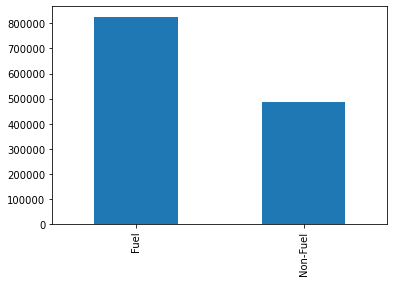

In [154]:
data.TR_PRODUCT_TYPE.value_counts().plot(kind = 'bar')

# Enregistrer les données propres

In [155]:
data.to_csv('./data/table_transactions.csv',sep=';',encoding='latin-1',index=False)